In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="whitegrid")

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

SEED = 1

# Summary

- 1. Load and clean data
- 2. Spearman rank correlation
- 3. Linear regression model 
- 4. Healthy score 
    - 4.1 Healthy score according to Wikipedia
    - 4.2 Healthy score according to the FDA
    - 4.3 Plot well-being as a function of different features and the three scores 
- 5. Regression
    - 5.1 Ordinary Least Squares regression
    - 5.2 Logit regression on the well-being
- 6. Classifier

In [3]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', ylim=[0,1.1], title='Validation Curve', ax=None, save_image=False, save_name="plot"):    
    """ 
    Plot a validation curve using train_scores and cv_scores.
    
    Input:
        train_scores  scores of the training
        cv_scores     scores of the cross-validation
        x_data        x axis (number of trees for random forest for example)
        x_label       label of x-axis
        y_label       label of y-axis
        ylim          span of the y axis
        title         title of the plot
        ax            ax of the plot
    """
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    lw = 2
    
    if ax == None: 
        plt.title(title, fontsize=20)
        plt.xlabel(x_label, fontsize=15)
        plt.ylabel(y_label, fontsize=15)
        plt.ylim(ylim)
        
        plt.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        plt.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        plt.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        plt.legend(loc='best', fontsize=15)
    else:
        ax.set_title(title, fontsize=20)
        ax.set_xlabel(x_label, fontsize=15)
        ax.set_ylabel(y_label, fontsize=15)
        ax.set_ylim(ylim)
        
        ax.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        ax.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        ax.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        ax.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        ax.legend(loc="best", fontsize=15)
        
    if save_image:
        fig = plt.gcf()
        fig.savefig("images\%s"%save_name, bbox_inches='tight')

In [4]:
def plot_confusion_matrix(cm, title='Confusion Matrix', ax=None, save_image=False, save_name="plot"):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Input:
        cm         sklearn confusion matrix 
        title      title of the plot
        ax         ax of the plot if given
    """
    
    sns.heatmap(data=pd.DataFrame(cm), vmin=0, annot=True, square=True, cmap=plt.cm.Reds, fmt='g', ax=ax)
    if ax == None:
        plt.xlabel('Predicted label', fontsize=15)
        plt.ylabel('True label', fontsize=15)
        plt.title(title, fontsize=20)
    else:
        ax.set_xlabel('Predicted label', fontsize=15)
        ax.set_ylabel('True label', fontsize=15)
        ax.set_title(title, fontsize=20)
    
    if save_image:
        fig = plt.gcf()
        fig.savefig("images\%s"%save_name, bbox_inches='tight')

In [5]:
def plot_barplot(x, y, title='Correlation', ylabel='R', save_image=False, save_name="plot"):
    """
    Plots a barplot.
    """
    plt.figure(figsize=(11,5))

    sns.set_style('darkgrid')
    plt.xticks(rotation=90)
    plt.ylabel(ylabel, fontsize=15)

    plt.title(title, fontsize=20, pad=15.0)
    plt.tick_params(labelsize=15)
    plt.axhline(y=0, color='black')

    sns.barplot(x=x,y=y)
    plt.show()
    
    if save_image:
        fig = plt.gcf()
        fig.savefig("images\%s"%save_name, bbox_inches='tight')

# 1. Load and clean data

In [6]:
df_well_being_raw = pd.read_excel("data/london-ward-well-being-probability-scores.xls", sheet_name="Dashboard", skiprows=12)
df_grocery_raw = pd.read_csv('data/year_osward_grocery.csv')

In [7]:
df_well_being_raw.head(2)

,Borough name,Ward Code,Ward name,Unnamed: 3,Unnamed: 4,2009,2010,2011,2012,2013,Unnamed: 10,Unnamed: 11,See full data set (e.g. numbers/rates),Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,City of London,E09000001,City of London,NaN,NaN,3.868138,2.584469,2.159794,1.046416,1.420837,NaN,-0.611825,NaN,NaN,NaN,-1.283670,-0.424675,-1.113377,0.374420,-0.611825
1,Barking and Dagenham,E05000026,Abbey,NaN,NaN,3.695918,3.854677,2.949578,1.542211,0.699065,NaN,-0.749213,NaN,NaN,NaN,0.158758,-0.905099,-1.407367,-0.843146,NaN


We chose to keep only the well being for the year 2013. The criteria to compute the well being are life expectancy, childhood obesity and happiness. As stated in the dataframe, "[well-being] scores over 0 indicate a higher probability that the population on average experiences positive well-being according to these measures."

In [8]:
df_well = df_well_being_raw[["Ward Code", 2013]]
df_well.columns = ['area_id', 'well_being']
df_well = df_well.drop(0)
df_well = df_well.dropna()

In [9]:
df_well.head(2)

,area_id,well_being
1,E05000026,0.699065
2,E05000027,-8.902220


In [10]:
# Select the columns of interest in the grocery DataFrame

df_grocery = df_grocery_raw[["area_id", "fat", "saturate", "salt", "sugar", "protein", "carb", "fibre", "alcohol", "energy_fat", 
                             "energy_saturate","energy_sugar", "energy_protein", "energy_carb", "energy_fibre", "energy_alcohol", 
                             "energy_tot", "h_nutrients_weight_norm", "h_nutrients_calories_norm", "f_beer", "f_dairy", "f_eggs",
                             "f_fats_oils", "f_fish", "f_fruit_veg", "f_grains", "f_meat_red", "f_poultry", "f_readymade",
                             "f_sauces", "f_soft_drinks", "f_spirits", "f_sweets", "f_tea_coffee", "f_water", "f_wine",
                             "f_fruit_veg_weight", "f_grains_weight", "f_dairy_weight", "f_meat_red_weight", "f_poultry_weight",
                             "f_eggs_weight", "f_fish_weight"]]

# Compute the percentage of weight for fda nutrients and energy of nutrients
nutrients = ["fat", "protein", "carb", "fibre", "alcohol"]
fda_nutrients = ["fat", "fibre", "carb", "protein", "saturate"]
weight_tot = df_grocery[fda_nutrients].sum(axis=1)
df_grocery_percentage = df_grocery.copy()

for nutrient in nutrients:
    df_grocery_percentage["percentage_%s_energy"%nutrient] = df_grocery_percentage["energy_%s"%nutrient] *100 / df_grocery["energy_tot"]

for nutrient in fda_nutrients:
    df_grocery_percentage["percentage_%s_weight"%nutrient] = df_grocery_percentage["%s"%nutrient] *100 / weight_tot

In [11]:
df_grocery_percentage.head(2)

,area_id,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,energy_fat,...,percentage_fat_energy,percentage_protein_energy,percentage_carb_energy,percentage_fibre_energy,percentage_alcohol_energy,percentage_fat_weight,percentage_fibre_weight,percentage_carb_weight,percentage_protein_weight,percentage_saturate_weight
0,E05000026,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,85.399176,...,45.640000,10.640657,41.433292,1.544686,0.741364,24.263835,4.001153,49.561651,12.728135,9.445226
1,E05000027,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,87.602703,...,46.439549,11.051200,40.183491,1.546797,0.778963,24.930197,4.051784,48.536438,13.348414,9.133168


In [12]:
# Merge the grocery DataFrame with the well-being one
df = df_well.merge(df_grocery_percentage, on='area_id')

In [13]:
df.head(2)

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,percentage_fat_energy,percentage_protein_energy,percentage_carb_energy,percentage_fibre_energy,percentage_alcohol_energy,percentage_fat_weight,percentage_fibre_weight,percentage_carb_weight,percentage_protein_weight,percentage_saturate_weight
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,45.640000,10.640657,41.433292,1.544686,0.741364,24.263835,4.001153,49.561651,12.728135,9.445226
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,46.439549,11.051200,40.183491,1.546797,0.778963,24.930197,4.051784,48.536438,13.348414,9.133168


# 2. Healthy score 
## 2.1 Healthy score according to Wikipedia
source: https://en.wikipedia.org/wiki/Healthy_diet

We used the table of "three healthy patterns" and picked the U.S. style. We converted all quantities in daily cups and computed the percentage of each food that lead to a healthy diet according to Wikipedia.

In [14]:
foods = dict(zip(["fruit_veg", "grains", "dairy", "meat_red", "poultry", "eggs", "fish"], [4.5, 0.75, 3, 1.5/7, 1.25/7, 0.375/7, 1/7]))
sum_values = sum(foods.values())

for food in foods.keys():
    foods[food] = foods[food]/sum_values

In [15]:
# foods is a dictionnary containing the percentage of type of food recommended per day
foods

{'fruit_veg': 0.5090909090909091,
 'grains': 0.08484848484848485,
 'dairy': 0.3393939393939394,
 'meat_red': 0.024242424242424242,
 'poultry': 0.020202020202020204,
 'eggs': 0.006060606060606061,
 'fish': 0.01616161616161616}

Create a "score" column in the DataFrame using:

$ score = 1 - \sum_{nutrient} (HealthyPortion_{nutrient} - f_{nutrient})^2$

The higher the score, the healthier the area eats. 

In [16]:
df_healthy = df.copy()
df_healthy.loc[:,"score"] =0
for food in foods:
    df_healthy["score"] += (df_healthy["f_%s"%food] - foods[food])**2
    
df_healthy["score"] = 1 - df_healthy["score"]

In [17]:
df_healthy.head(2)

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,percentage_protein_energy,percentage_carb_energy,percentage_fibre_energy,percentage_alcohol_energy,percentage_fat_weight,percentage_fibre_weight,percentage_carb_weight,percentage_protein_weight,percentage_saturate_weight,score
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,10.640657,41.433292,1.544686,0.741364,24.263835,4.001153,49.561651,12.728135,9.445226,0.874300
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,11.051200,40.183491,1.546797,0.778963,24.930197,4.051784,48.536438,13.348414,9.133168,0.869042


### Perform Spearman rank correlation on the healthy score and well-being

In [18]:
stats.spearmanr(df_healthy["score"],df_healthy['well_being'])

SpearmanrResult(correlation=0.22672170628643162, pvalue=4.765268124884234e-07)

The p-value is lower than 0.05 and the correlation is positive. It seems that eating healthy according to Wikipedia leads to a high well-being.

## 2.2 Healthy score according to the FDA
source: https://www.fda.gov/media/135301/download pages 4 to 6.

We used the weight of each nutrient in the table and computed a percentage of nutrients that lead to a healthy diet according to the FDA. 
The table presents "original" and "updated" values, so we computed scores according to both.

In [19]:
foods_fda_updated = dict(zip(["fat", "fibre", "carb", "protein", "saturate"], [78, 28, 275, 50, 20]))
foods_fda_old = dict(zip(["fat", "fibre", "carb", "protein", "saturate"], [65, 25, 300, 50, 20]))

#saturate is included in fat so we do not include it in the sum of nutrients
sum_values_fda_updated = sum(list(foods_fda_updated.values())[:-1])
sum_values_fda_old = sum(list(foods_fda_old.values())[:-1])

# compute percentage of nutrients for a healthy diet
for food in foods_fda_updated.keys():
    foods_fda_updated[food] = foods_fda_updated[food]/sum_values_fda_updated
    foods_fda_old[food] = foods_fda_old[food]/sum_values_fda_old

In [20]:
df_fda = df_healthy[["area_id", "well_being", "fat", "fibre", "carb", "protein", "saturate"]]

df_fda_percentage = df_fda.copy()

#2:5 --> not the saturated for the sum because they are included in fat
df_fda_percentage["weight_tot"] = df_fda.iloc[:,2:5].sum(axis=1)

#2:6 --> only for nutrients
for nutrient in df_fda_percentage.columns[2:7]:
    df_fda_percentage["percentage_%s"%nutrient] = df_fda_percentage["%s"%nutrient] / df_fda_percentage["weight_tot"]

Create a "score" column in the DataFrame using:

$ score = 1 - \sum_{nutrient} (HealthyPortion_{nutrient} - f_{nutrient})^2$

The higher the score, the healthier the area eats. 

In [21]:
## Compute the scores according to the FDA (using the old and updated values)
df_fda_percentage.loc[:,"score_updated"] = 0
df_fda_percentage.loc[:,"score_old"] = 0

for nutrient in  df_fda_percentage.columns[2:7]:
    df_fda_percentage["score_updated"] += (df_fda_percentage["percentage_%s"%nutrient] - foods_fda_updated[nutrient])**2    
    df_fda_percentage["score_old"] += (df_fda_percentage["percentage_%s"%nutrient] - foods_fda_old[nutrient])**2
    
df_fda_percentage["score_updated"] = 1 - df_fda_percentage["score_updated"]
df_fda_percentage["score_old"] = 1 - df_fda_percentage["score_old"]

In [22]:
df_fda_percentage.head(2)

,area_id,well_being,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score_updated,score_old
0,E05000026,0.699065,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.974829,0.962784
1,E05000027,-8.902220,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.971663,0.957979


### Perform Spearman rank correlation between the healthy scores and well-being

In [23]:
stats.spearmanr(df_fda_percentage["score_old"],df_fda_percentage['well_being'])

SpearmanrResult(correlation=-0.14228237280243905, pvalue=0.001719492165504676)

In [24]:
stats.spearmanr(df_fda_percentage["score_updated"],df_fda_percentage['well_being'])

SpearmanrResult(correlation=-0.13257400923253018, pvalue=0.003512028483104444)

Both p-values are lower than 0.05 and both correlations are negative. According to the FDA, is eating healthy bad for one's well-being ?

## 2.3 Plot well-being as a function of different features and the three scores 
(the empty plot is not an error but we have 39 plot for 40 slots). We see that there is rarely a correlation between the nutrients and energy, and the well-being. However, for some nutrients we can see a trend: 
 - for `f_water` (row 1 column 4), the higher the fraction of water, the lower the well-being.
 - for `f_wine`  (row 2 column 5), the higher the fraction of wine, the higher the well-being.
 
...interesting !!

<img src="images/drake.jpg" width="400">
<img src="images/correlation.jpg" width="400">



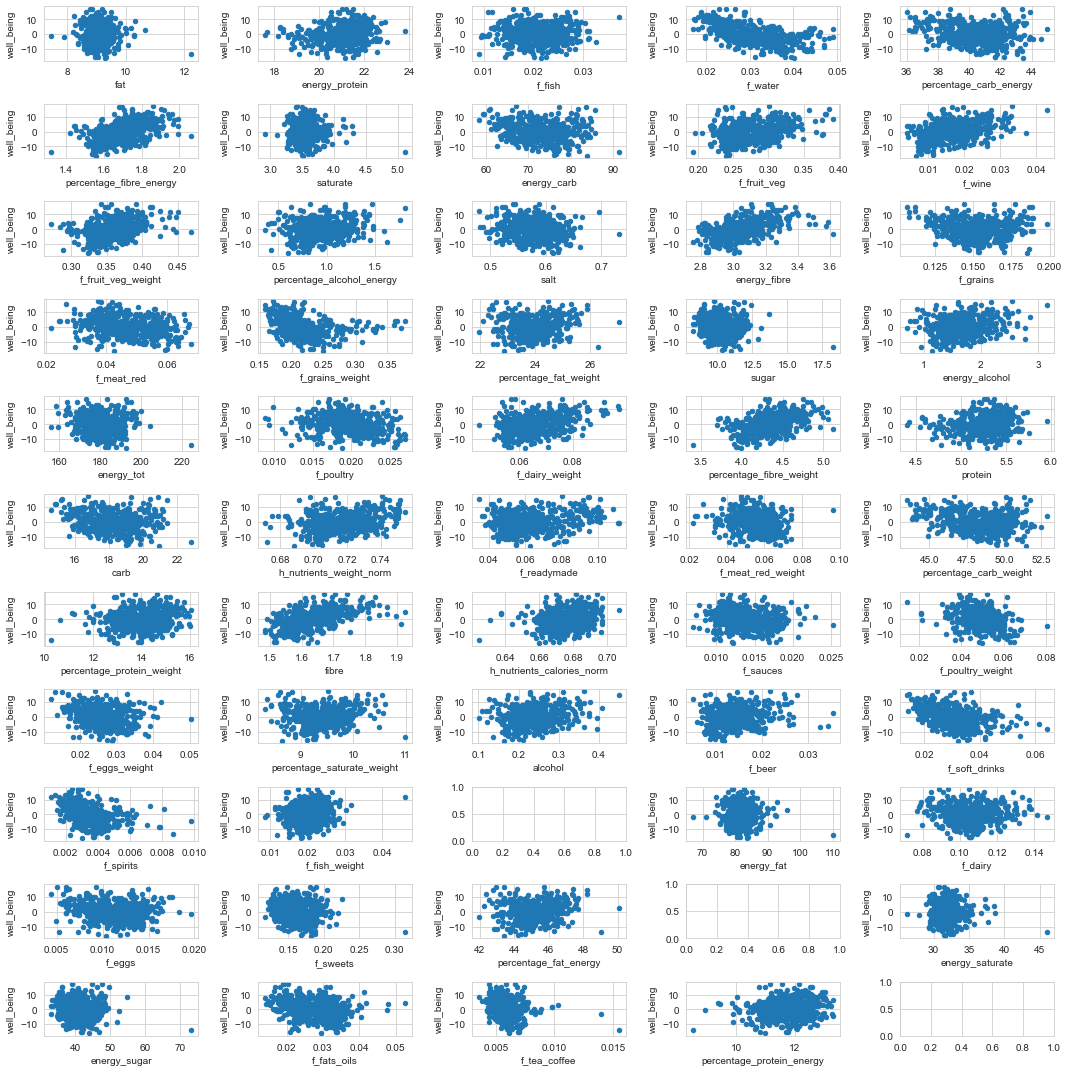

In [25]:
fig, axes = plt.subplots(nrows=11, ncols=5, tight_layout=True, figsize=(15, 15))

for i, feature in enumerate(df_healthy.columns[2:-1]):
    df_healthy.plot(x=feature, y='well_being', kind='scatter', ax=axes[i%11][i%5])

Plot well-being as a function of the Wikipedia score and FDA old and updated scores. Sadly, we cannot see any correlation.

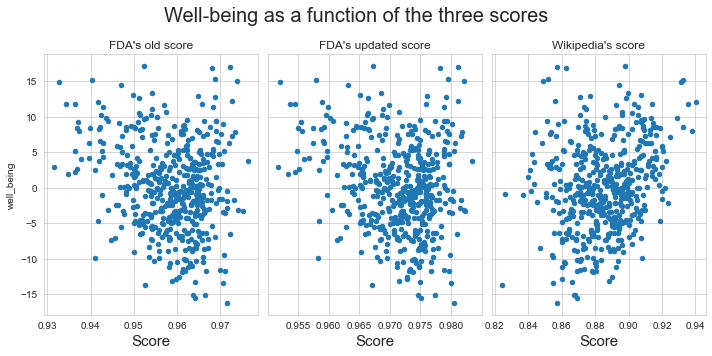

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, tight_layout=True, figsize=(10,5), sharey=True)
df_fda_percentage.plot(x='score_old', y='well_being', kind='scatter', ax=axes[0], title='FDA\'s old score')
df_fda_percentage.plot(x='score_updated', y='well_being', kind='scatter', ax=axes[1], title='FDA\'s updated score')
df_healthy.plot(x='score', y='well_being', kind='scatter', ax=axes[2], title='Wikipedia\'s score')

for ax in axes:
    ax.set_xlabel('Score', fontsize=15)
plt.suptitle("Well-being as a function of the three scores", fontsize=20)
plt.show()

We cannot see a trend between the scores and well-being.

# 3. Spearman rank correlation

We decided to perform a Spearman correlation between:
 - the percentage of nutrients and the well-being
 - the weight of the nutrients and the well-being
 - the energy for each nutrient and the well-being
 - the entropy of nutrients and the well-being
 - the weight's fraction of food categories and the well-being

In [27]:
spearman_nutrients = {}
spearman_nutrients_plot = {}
spearman_weight = {}
spearman_weight_plot = {}
spearman_energy = {}
spearman_energy_plot = {}

for nutrient in nutrients:
    spearman_nutrients[nutrient] = stats.spearmanr(df["percentage_%s_energy"%nutrient],df["well_being"])
    spearman_nutrients_plot[nutrient] = [spearman_nutrients[nutrient].correlation]
    
    spearman_weight[nutrient] = stats.spearmanr(df["%s"%nutrient],df["well_being"])
    spearman_weight_plot[nutrient] = [spearman_weight[nutrient].correlation]
    
    spearman_energy[nutrient] = stats.spearmanr(df["energy_%s"%nutrient],df["well_being"])
    spearman_energy_plot[nutrient] = [spearman_energy[nutrient].correlation]

# Spearman rank correlation for the entropies relative to the weight and energy of the nutrients
spearman_weight["entropy"] = stats.spearmanr(df["h_nutrients_weight_norm"], df["well_being"])
spearman_weight_plot["entropy"] = [spearman_weight["entropy"].correlation]

spearman_energy["entropy"] = stats.spearmanr(df["h_nutrients_calories_norm"],df["well_being"])
spearman_energy_plot["entropy"] = [spearman_energy["entropy"].correlation]

# Spearman rank correlation relative to the percentage weight for fda nutrients
spearman_weight_fda = {}
spearman_weight_fda_plot = {}

for nutrient in fda_nutrients:
    spearman_weight_fda[nutrient] = stats.spearmanr(df["percentage_%s_weight"%nutrient],df["well_being"])
    spearman_weight_fda_plot[nutrient] = [spearman_weight_fda[nutrient].correlation]

# Spearman rank correlation relative to the food categories
food_categories = ["fruit_veg", "grains", "dairy", "meat_red", "poultry", "eggs", "fish"]
spearman_categories = {}
spearman_categories_plot = {}

for category in food_categories:
    spearman_categories[category] = stats.spearmanr(df["f_%s_weight"%category],df['well_being'])
    spearman_categories_plot[category] = [spearman_categories[category].correlation]
    
# Spearman rank correlation for scores
spearman_weight_fda["score_old"] = stats.spearmanr(df_fda_percentage["score_old"], df_fda_percentage['well_being'])
spearman_weight_fda_plot["score_old"] = [spearman_weight_fda["score_old"].correlation]
spearman_weight_fda["score_updated"] = stats.spearmanr(df_fda_percentage["score_updated"], df_fda_percentage['well_being'])
spearman_weight_fda_plot["score_updated"] = [spearman_weight_fda["score_updated"].correlation]

spearman_categories["score"] = stats.spearmanr(df_healthy["score"], df_healthy['well_being'])
spearman_categories_plot["score"] = [spearman_categories["score"].correlation]

# Sort in increasing order
spearman_nutrients_plot = {key: value for key, value in sorted(spearman_nutrients_plot.items(), key=lambda item: item[1])}
spearman_weight_plot = {key: value for key, value in sorted(spearman_weight_plot.items(), key=lambda item: item[1])}
spearman_energy_plot = {key: value for key, value in sorted(spearman_energy_plot.items(), key=lambda item: item[1])}
spearman_weight_fda_plot = {key: value for key, value in sorted(spearman_weight_fda_plot.items(), key=lambda item: item[1])}
spearman_categories_plot = {key: value for key, value in sorted(spearman_categories_plot.items(), key=lambda item: item[1])}

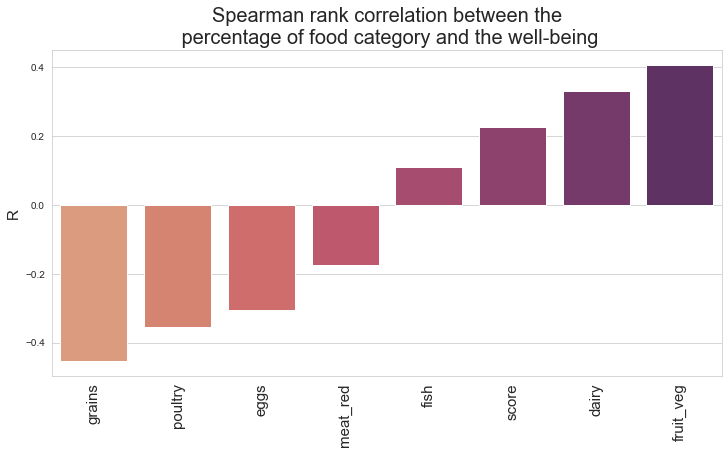

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(data=pd.DataFrame(spearman_categories_plot),
            order=list(spearman_categories_plot.keys()), palette='flare')
plt.title("Spearman rank correlation between the\n percentage of food category and the well-being", fontsize=20)
plt.ylabel('R', fontsize=15)
plt.gca().set_xticklabels(
    labels=plt.gca().get_xticklabels(),
    rotation=90, 
    horizontalalignment='center',
    fontsize=15)
plt.gcf().savefig("images/spearman_wiki_score.png", bbox_inches='tight');

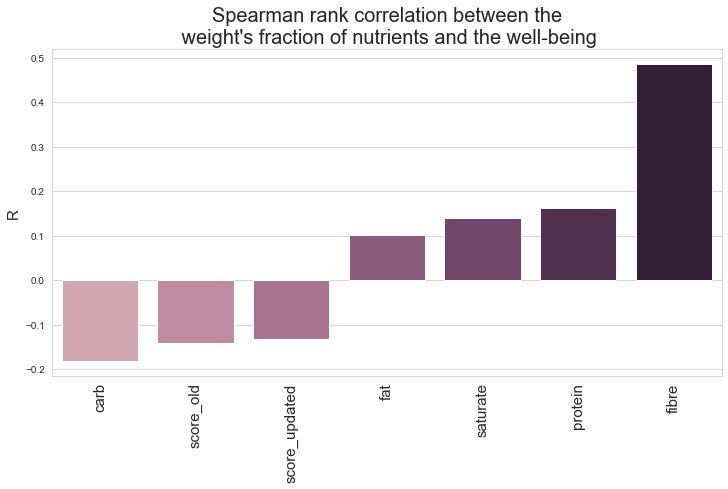

In [29]:
plt.figure(figsize=(12,6))
sns.barplot(data=pd.DataFrame(spearman_weight_fda_plot),
            order=list(spearman_weight_fda_plot.keys()), palette='ch:s=.25,rot=.25,light=0.7')
plt.title("Spearman rank correlation between the\n weight's fraction of nutrients and the well-being", fontsize=20)
plt.ylabel('R', fontsize=15)
plt.gca().set_xticklabels(
    labels=plt.gca().get_xticklabels(),
    rotation=90, 
    horizontalalignment='center',
    fontsize=15)
plt.gcf().savefig("images/spearman_fda_score.png", bbox_inches='tight');

In these correlations the p-value is always lower than 0.05 except for the weight and energy of fat. We can see that the correlation of fibre with well-being is high. The correlation between the entropy of nutrients and well-being is high and with a p-value lower than 0.05.

# 4. Regression
## 4.1 Ordinary Least Squares regression

We tried to to fit a linear regression model to :
 - the weight of nutrients 
 - fraction of products purchased
 - Wikipedia healthy score
 - FDA healthy scores

In [30]:
# Fit linear regression model to nutrients
mod = smf.ols(formula='well_being ~  fat + sugar + alcohol + carb + saturate + protein + fibre', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     44.65
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.91e-48
Time:                        16:02:21   Log-Likelihood:                -1448.7
No. Observations:                 483   AIC:                             2913.
Df Residuals:                     475   BIC:                             2947.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -79.8253      9.492     -8.410      0.0

In [31]:
# Fit logistic regression model to foods
mod = smf.ols(formula='well_being ~  f_beer + f_dairy + f_eggs + f_fats_oils + f_fish + f_fruit_veg + f_grains +'
              + 'f_meat_red + f_poultry + f_readymade + f_sauces + f_soft_drinks + f_spirits + f_sweets + '
              + 'f_tea_coffee + f_water + f_wine', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     24.80
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.74e-52
Time:                        16:02:21   Log-Likelihood:                -1422.1
No. Observations:                 483   AIC:                             2878.
Df Residuals:                     466   BIC:                             2949.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -50.6805     20.895     -2.426

In [32]:
# Fit logistic regression model to Wikipedia's score
mod = smf.ols(formula='well_being ~ score', data=df_healthy)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     29.49
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           8.92e-08
Time:                        16:02:22   Log-Likelihood:                -1556.4
No. Observations:                 483   AIC:                             3117.
Df Residuals:                     481   BIC:                             3125.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -68.4837     12.622     -5.426      0.0

In [33]:
# Fit logistic regression model to FDA's old score
mod = smf.ols(formula='well_being ~ score_old', data=df_fda_percentage)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     19.94
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           9.95e-06
Time:                        16:02:22   Log-Likelihood:                -1561.0
No. Observations:                 483   AIC:                             3126.
Df Residuals:                     481   BIC:                             3134.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    145.6265     32.599      4.467      0.0

In [34]:
# Fit logistic regression model to FDA's updated score
mod = smf.ols(formula='well_being ~ score_updated', data=df_fda_percentage)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     18.69
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.87e-05
Time:                        16:02:23   Log-Likelihood:                -1561.6
No. Observations:                 483   AIC:                             3127.
Df Residuals:                     481   BIC:                             3136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       195.5049     45.211      4.324

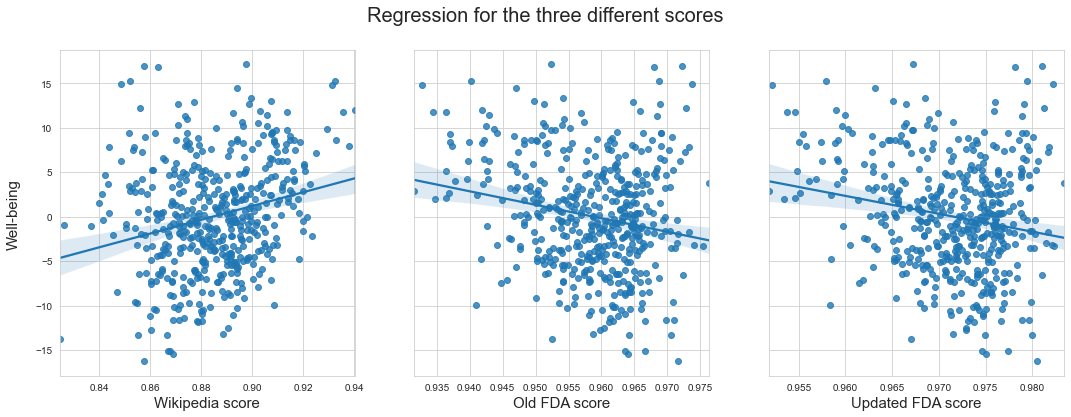

In [35]:
fig, axes = plt.subplots(1,3,figsize=(18,6), sharey=True)

score_names = ["score", "score_old", "score_updated"]
snames = ["Wikipedia score", "Old FDA score", "Updated FDA score"]
dfs = [df_healthy, df_fda_percentage, df_fda_percentage]
for ax, score_name, temp_df, name in zip(axes, score_names, dfs, snames):
    plt.sca(ax)
    sns.regplot(x=score_name, y="well_being", data=temp_df)
    ax.set_xlabel(name, fontsize=15)
    ax.set_ylabel("")

fig.text(0.09, 0.5, 'Well-being', ha='center', va='center', rotation='vertical', fontsize=15)
fig.suptitle("Regression for the three different scores", fontsize=20)
fig.savefig("images/regression_scores.png", bbox_inches='tight')

In the three regressions, R-squared is low so the explained variance is low. The low explained variance is much apparent on the above plots. The p-value is lower than 0.05 so we would need more parameters than the scores to explain the well-being.

## 5.2 Logit regression on the well-being

Plot the distribution of the well-being. Scores over 0 indicate a higher probability that the population on average experiences positive well-being. We decided to try to transform the problem in a classification problem with two classes: happy (well-being>=0) and unhappy (well-being<0).

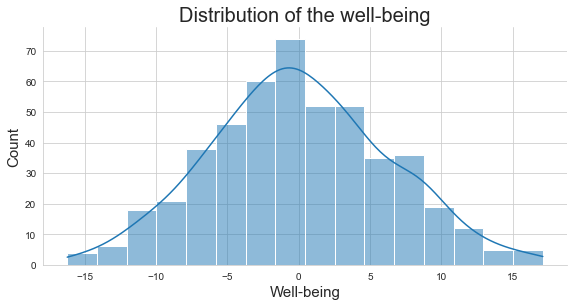

In [36]:
sns_plot = sns.displot(df_fda_percentage["well_being"], kde=True, height=4, aspect=2)
plt.title('Distribution of the well-being', fontsize=20)
plt.xlabel("Well-being", fontsize=15)
plt.ylabel(plt.gca().get_ylabel(), fontsize=15)
plt.show()
sns_plot.savefig("images/distrib_well_being", bbox_inches='tight');

### Create 'well' variable for FDA definition 
`well` is zero for negative well-being and one for positive well-being.

In [37]:
# Create the column in the FDA DataFrame
df_fda_wellness = df_fda_percentage.copy()
df_fda_wellness.loc[df_fda_wellness['well_being'] >= 0, 'well'] = 1
df_fda_wellness.loc[df_fda_wellness['well_being'] < 0, 'well'] = 0

In [38]:
df_fda_wellness.head(2)

,area_id,well_being,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score_updated,score_old,well
0,E05000026,0.699065,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.974829,0.962784,1.0
1,E05000027,-8.902220,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.971663,0.957979,0.0


Let's plot the classes as a function of the updated FDA healthy diet score. Sadly, the plot shows no clear tendency.

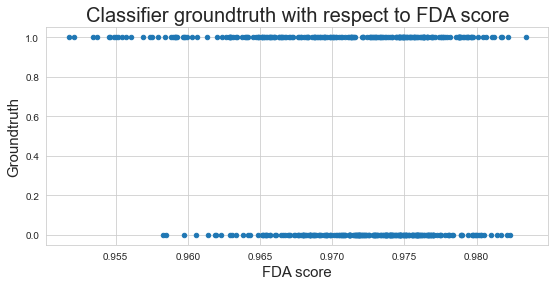

In [39]:
ax = df_fda_wellness.plot(x='score_updated', y='well', kind='scatter', figsize=(9,4))
plt.title('Classifier groundtruth with respect to FDA score', fontsize=20)
plt.xlabel("FDA score", fontsize=15)
plt.ylabel("Groundtruth", fontsize=15)
plt.show()
ax.get_figure().savefig("images/well_fda_score", bbox_inches='tight')

### Create 'well' variable for Wikipedia definition 
well is zero for negative well-being and one for positive well-being.

In [40]:
# Create the column in the Wikipedia DataFrame
df_healthy_well = df_healthy.copy()

df_healthy_well.loc[df_healthy_well['well_being'] >= 0, 'well'] = 1
df_healthy_well.loc[df_healthy_well['well_being'] < 0, 'well'] = 0

In [41]:
df_healthy_well.head(2)

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,percentage_carb_energy,percentage_fibre_energy,percentage_alcohol_energy,percentage_fat_weight,percentage_fibre_weight,percentage_carb_weight,percentage_protein_weight,percentage_saturate_weight,score,well
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,41.433292,1.544686,0.741364,24.263835,4.001153,49.561651,12.728135,9.445226,0.874300,1.0
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,40.183491,1.546797,0.778963,24.930197,4.051784,48.536438,13.348414,9.133168,0.869042,0.0


Let's plot the classes as a function of the healthy diet score. Sadly, the plot shows no clear tendency.

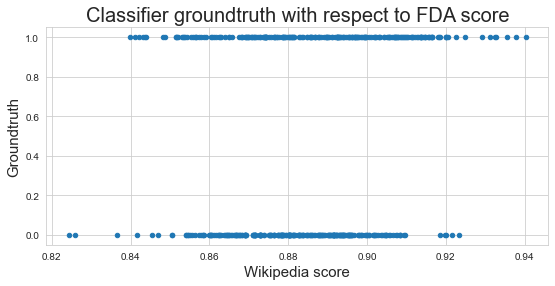

In [42]:
ax = df_healthy_well.plot(x='score', y='well', kind='scatter', figsize=(9,4))
plt.title('Classifier groundtruth with respect to FDA score', fontsize=20)
plt.xlabel("Wikipedia score", fontsize=15)
plt.ylabel("Groundtruth", fontsize=15)
plt.show()
ax.get_figure().savefig("images/well_wiki_score", bbox_inches='tight');

# 6. Classifier

We decided to train a classifier to predict the class (positive or negative well-being) for each area.

In [43]:
# Split into train and test
X = df_fda_wellness[["score_updated", "percentage_fat", "percentage_fibre", "percentage_carb", "percentage_protein", "percentage_saturate"]]
y = df_fda_wellness["well"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [44]:
# Use a Random Forest Classifier to predict labels
N_values  = np.array([int(i) for i in np.linspace(5.0, 200, 5)])
model     = RandomForestClassifier(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED, shuffle=True)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='accuracy',
                                                   param_name = "n_estimators", 
                                                   param_range = N_values,
                                                   cv=cv_schema)

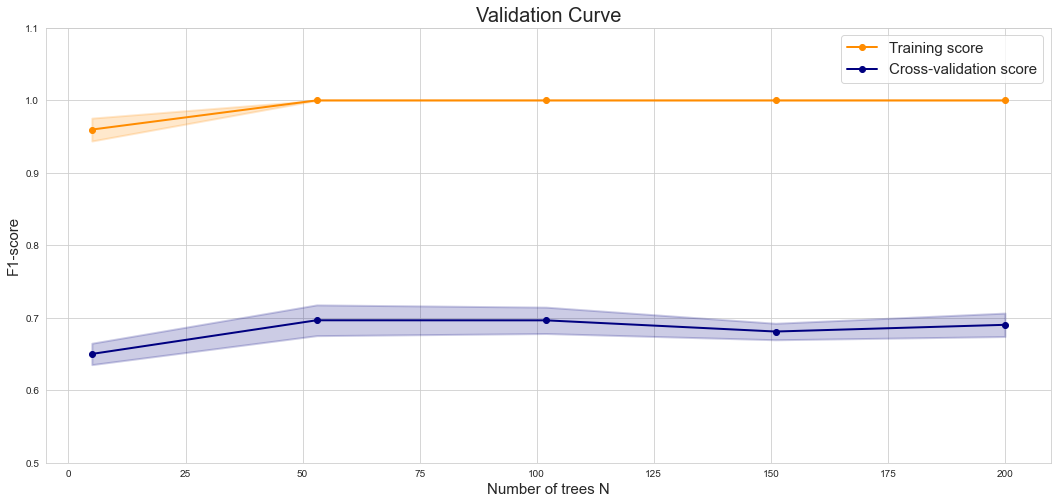

In [45]:
# Plot a validation curve across levels of K
random_forest_fig = plt.figure(figsize=(18,8))
plot_validation_curve(train_scores_val,
                      cv_scores_val,
                      N_values, y_label='F1-score',
                      ylim = [0.5, 1.1],
                      x_label='Number of trees N',
                      save_image=True,
                      save_name="valid_curve.png")

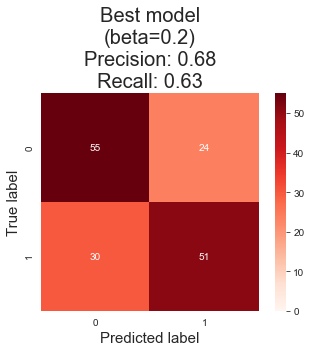

In [46]:
# Best random forest
thresh = 0.5

RF = RandomForestClassifier(n_estimators=60, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat = RF.predict_proba(X_test)[:,1] > thresh
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Best model\n(beta=0.2)\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title, save_image=True, save_name="confusion_matrix.png")

plt.show()

---